In [1]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.sampler import SequentialSampler
import skimage
from multiprocessing import Pool
from progressbar import progressbar as pb
import matplotlib.pyplot as plt
from IPython.display import clear_output
from matplotlib.backends.backend_pdf import PdfPages

torch.cuda.get_device_name(0)

'Tesla M60'

In [2]:
%%javascript
$('.nbp-app-bar').toggle()

<IPython.core.display.Javascript object>

In [3]:
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [4]:
train_inds = list(np.random.choice(np.arange(50000), 5000))
test_inds = list(np.random.choice(np.arange(10000), 1000))

In [5]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=preprocess)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=24, 
                                          num_workers=0, sampler=SequentialSampler(train_inds))

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=preprocess)
testloader = torch.utils.data.DataLoader(testset, batch_size=24,
                                         num_workers=0, sampler=SequentialSampler(test_inds))

Files already downloaded and verified
Files already downloaded and verified


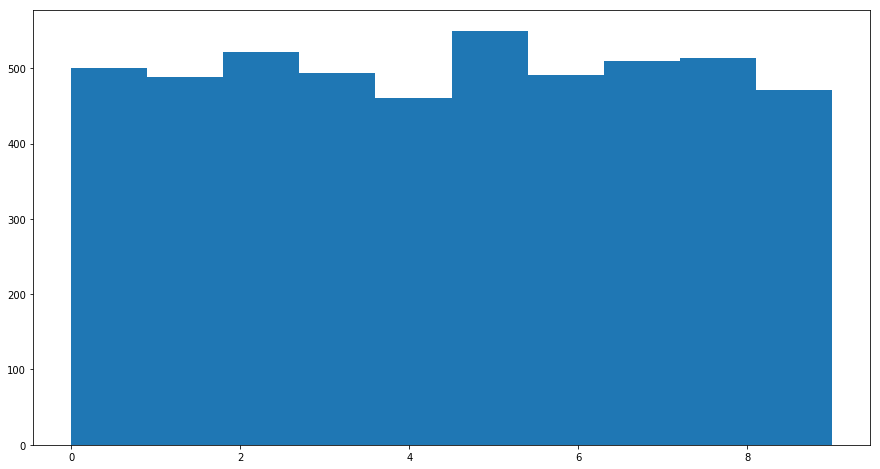

In [19]:
labels = np.array(trainloader.dataset.train_labels)[train_inds]

f = plt.figure(figsize=(15,8))
plt.hist(labels, bins=10)
pp = PdfPages('first_distrib_train.pdf')
pp.savefig(f)
pp.close()
f.savefig('first_distrib_train.png')
plt.show()

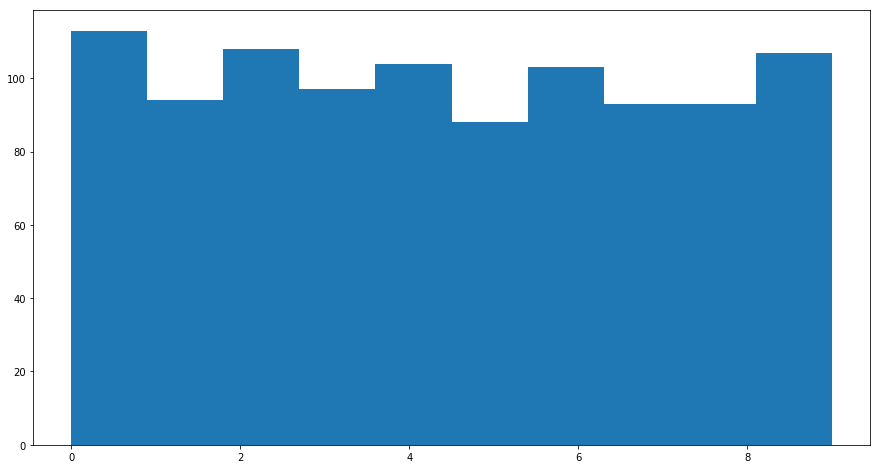

In [17]:
labels = np.array(testloader.dataset.test_labels)[test_inds]
f = plt.figure(figsize=(15,8))
plt.hist(labels, bins=10)
pp = PdfPages('first_distrib_test.pdf')
pp.savefig(f)
pp.close()
f.savefig('first_distrib_test.png')
plt.show()

In [ ]:
class VGG2(nn.Module):
    def __init__(self, batchnorm=False):
        super(VGG2, self).__init__()
        self.batchnorm = batchnorm
        
        self.pool = nn.MaxPool2d(2, 2)

        self.conv1_1 = nn.Conv2d(3, 64, 3, 1)

        self.conv2_1 = nn.Conv2d(64, 128, 3, 1)

        self.conv3_1 = nn.Conv2d(128, 256, 3, 1)
        self.conv3_2 = nn.Conv2d(256, 256, 3, 1)

        self.conv4_1 = nn.Conv2d(256, 512, 3, 1)
        self.conv4_2 = nn.Conv2d(512, 512, 3, 1)

        self.conv5_1 = nn.Conv2d(512, 512, 3, 1)
        self.conv5_2 = nn.Conv2d(512, 512, 3, 1)

        self.fc1 = nn.Linear(4608, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.out = nn.Linear(4096, 10)

        if self.batchnorm:
            self.bn1 = nn.BatchNorm2d(64)
            self.bn2 = nn.BatchNorm2d(128)
            self.bn3 = nn.BatchNorm2d(256)
            self.bn4 = nn.BatchNorm2d(512)
            self.bn5 = nn.BatchNorm1d(4096)
            
    def forward(self, x):
        if not self.batchnorm:
            x = F.relu(self.conv1_1(x))
            x = self.pool(x)

            x = F.relu(self.conv2_1(x))
            x = self.pool(x)

            x = F.relu(self.conv3_1(x))
            x = F.relu(self.conv3_2(x))
            x = self.pool(x)

            x = F.relu(self.conv4_1(x))
            x = F.relu(self.conv4_2(x))
            x = self.pool(x)

            x = F.relu(self.conv5_1(x))
            x = F.relu(self.conv5_2(x))
            x = self.pool(x)
            x = x.view(x.shape[0], -1)

            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.out(x)
            #x = nn.Softmax(x)
        else:
            x = F.relu(self.bn1(self.conv1_1(x)))
            x = self.pool(x)

            x = F.relu(self.bn2(self.conv2_1(x)))
            x = self.pool(x)

            x = F.relu(self.bn3(self.conv3_1(x)))
            x = F.relu(self.bn3(self.conv3_2(x)))
            x = self.pool(x)

            x = F.relu(self.bn4(self.conv4_1(x)))
            x = F.relu(self.bn4(self.conv4_2(x)))
            x = self.pool(x)

            x = F.relu(self.bn4(self.conv5_1(x)))
            x = F.relu(self.bn4(self.conv5_2(x)))
            x = self.pool(x)
            x = x.view(x.shape[0], -1)

            x = F.relu(self.bn5(self.fc1(x)))
            x = F.relu(self.bn5(self.fc2(x)))
            x = self.out(x)
        
        return x

In [ ]:
def train(model, train_loader, optimizer):
    train_acc = []
    model.train()
    for i, batch in enumerate(pb(train_loader)):
        X_batch, y_batch = batch
        X_batch = X_batch.type(torch.cuda.FloatTensor)
        y_batch = y_batch.type(torch.cuda.LongTensor)

        optimizer.zero_grad()

        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        
        max_ind = y_pred.max(1, keepdim=True)[1]
        target_matches = torch.eq(max_ind, y_batch.data.view(len(y_batch), 1))
        accuracy = torch.sum(target_matches).cpu().numpy() / len(y_batch)
        
        train_acc.append(accuracy)
        
        loss.backward()
        optimizer.step()
        
    return np.mean(train_acc) * 100

In [ ]:
def validate(model, val_loader):
    model.eval()
    val_acc = []
    for i, batch in enumerate(pb(val_loader)):
        X_batch, y_batch = batch
        X_batch = X_batch.type(torch.cuda.FloatTensor)
        y_batch = y_batch.type(torch.cuda.LongTensor)
        
        y_pred = model(X_batch)
        
        loss = loss_fn(y_pred, y_batch)
        
        max_ind = y_pred.max(1, keepdim=True)[1]
        target_matches = torch.eq(max_ind, y_batch.data.view(len(y_batch), 1))
        accuracy = torch.sum(target_matches).cpu().numpy() / len(y_batch)

        val_acc.append(accuracy)        

    
    return np.mean(val_acc) * 100

Epoch: 25, BN=False, LR=0.1
Train accuracy: 22.627591706539075
Test accuracy: 25.595238095238095


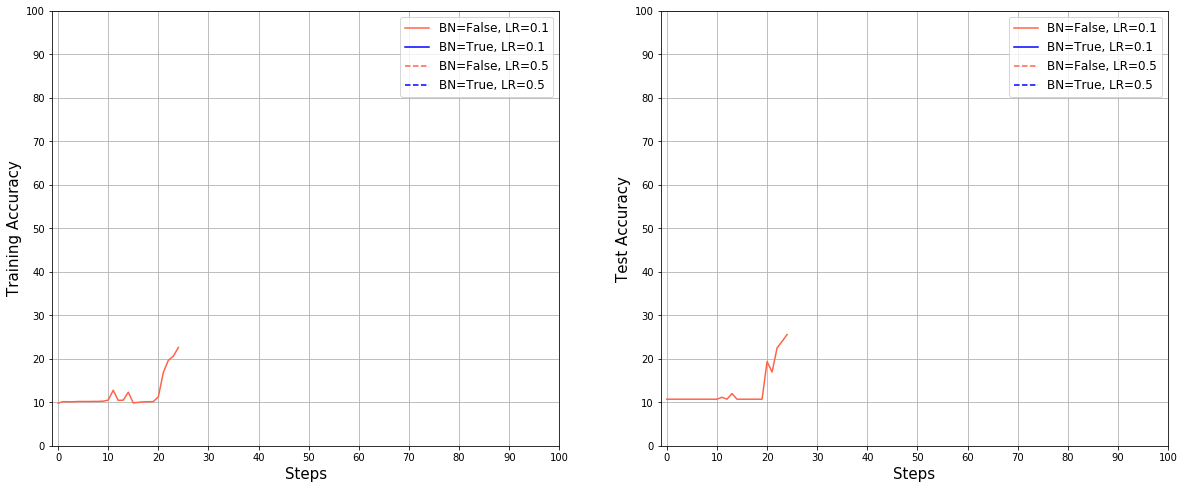

 70% (148 of 209) |###############       | Elapsed Time: 0:00:43 ETA:   0:00:17

In [ ]:
train_h = {(False, 0.1): [], (False, 0.5): [], (True, 0.1): [], (True, 0.5): []}
test_h = {(False, 0.1): [], (False, 0.5): [], (True, 0.1): [], (True, 0.5): []}

batch_flag, l_rates = [False, True], [0.1, 0.5]

for flag in batch_flag:
    for rate in l_rates:
        net = VGG2(flag)
        net.cuda()
        loss_fn = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(net.parameters(), lr=rate)
        

        for epoch in pb(range(101)):
            cur_train = train(net, trainloader, optimizer)
            cur_test = validate(net, testloader)
            train_h[(flag, rate)].append(cur_train)
            test_h[(flag, rate)].append(cur_test)
            clear_output()
            print('Epoch: {}, BN={}, LR={}'.format(epoch+1, flag, rate))
            print("Train accuracy: {}".format(cur_train))
            print("Test accuracy: {}".format(cur_test))

            f, axarr = plt.subplots(1,2, figsize=(20,8))

            axarr[0].plot(train_h[(False, 0.1)], color='tomato', label='BN={}, LR={}'.format(False, 0.1))
            axarr[0].plot(train_h[(True, 0.1)], color='blue', label='BN={}, LR={}'.format(True, 0.1))
            axarr[0].plot(train_h[(False, 0.5)], color='tomato', linestyle='--', label='BN={}, LR={}'.format(False, 0.5))
            axarr[0].plot(train_h[(True, 0.5)], color='blue', linestyle='--', label='BN={}, LR={}'.format(True, 0.5))
            axarr[0].grid()
            axarr[0].legend(fontsize=12)
            axarr[0].set_ylabel('Training Accuracy', size=15)
            axarr[0].set_xlabel('Steps', size=15)
            axarr[0].set_yticks(np.arange(0,101,10))
            axarr[0].set_yticklabels(np.arange(0,101,10))
            axarr[0].set_xticks(np.arange(0,110,10))
            axarr[0].set_xticklabels(np.arange(0,110,10))

            axarr[1].plot(test_h[(False, 0.1)], color='tomato', label='BN={}, LR={}'.format(False, 0.1))
            axarr[1].plot(test_h[(True, 0.1)], color='blue', label='BN={}, LR={}'.format(True, 0.1))
            axarr[1].plot(test_h[(False, 0.5)], color='tomato', linestyle='--', label='BN={}, LR={}'.format(False, 0.5))
            axarr[1].plot(test_h[(True, 0.5)], color='blue', linestyle='--', label='BN={}, LR={}'.format(True, 0.5))
            axarr[1].grid()
            axarr[1].legend(fontsize=12)
            axarr[1].set_ylabel('Test Accuracy', size=15)
            axarr[1].set_xlabel('Steps', size=15)
            axarr[1].set_yticks(np.arange(0,101,10))
            axarr[1].set_yticklabels(np.arange(0,101,10))
            axarr[1].set_xticks(np.arange(0, 110,10))
            axarr[1].set_xticklabels(np.arange(0,110,10))
            pp = PdfPages('first_2.pdf')
            pp.savefig(f)
            pp.close()
            f.savefig('first_2.png')
            plt.show()